In [1]:
# Only run on initial setup
%pip install tensorflow
%pip install opencv-contrib-python-headless
%pip install imutils


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow import keras
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,  ModelCheckpoint
from keras.layers import LeakyReLU
from sklearn import metrics
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
epochs = 30                 # Number of Training Epochs
num_classes = 10            # Number of classes in the Fashion MNIST dataset
batch_size = 256
img_rows, img_cols = 28, 28 # Pixel sizes of the Images in the Dataset

In [4]:
# Get the data from the keras repository
mnist_data = fashion_mnist.load_data()

# x = images, y = labels
x = mnist_data[0][0]
y = mnist_data[0][1]

# Split data test(20%), train(70%), and validation(10%) sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=41)

In [5]:
print(len(x),len(x_train),len(x_test),len(x_val))

60000 42000 12000 6000


In [6]:
# Process the date into the right tensor shape.   
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
    
# Cast to a 32 bit float and then scale so the value is a float normalized between 0 and 1. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_test /= 255
x_val /= 255

# Convert Class Vector to Binary Class Matrices (one-hot encoding).
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(y_test.shape)

# Function to decode one-hot encoding later on when evaluating performance.
def decode_one_hot(y):
    y_classes = [np.argmax(yi, axis=None, out=None) for yi in y]
    return y_classes


(12000, 10)


In [7]:
# Define sequential model and add layers
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# Print model summary
model.summary()
my_callbacks = [ModelCheckpoint('model_out.keras', monitor='accuracy', save_best_only=True)]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0

In [8]:
# Compile the model so we can fit it.
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Nadam(), 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Fit the model and evaluate the performance.
hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_data=(x_test, y_test),
                 callbacks=my_callbacks
                )

score = model.evaluate(x_test, y_test)

# Predict on the test data and pass to metrics function
yhat = np.argmax(model.predict(x_test), axis=-1)
y_dec = decode_one_hot(y_test)

print(metrics.classification_report(y_dec, yhat))
print("Testing Loss:", score[0])
print("Testing Accuracy:", score[1])


Epoch 1/30
165/165 [==============================] - 7s 38ms/step - loss: 0.8121 - accuracy: 0.7019 - precision: 0.8230 - recall: 0.5898 - auc: 0.9633 - val_loss: 0.4756 - val_accuracy: 0.8253 - val_precision: 0.8836 - val_recall: 0.7643 - val_auc: 0.9869
Epoch 2/30
165/165 [==============================] - 6s 38ms/step - loss: 0.4952 - accuracy: 0.8197 - precision: 0.8680 - recall: 0.7662 - auc: 0.9851 - val_loss: 0.4057 - val_accuracy: 0.8546 - val_precision: 0.8931 - val_recall: 0.8124 - val_auc: 0.9902
Epoch 3/30
165/165 [==============================] - 7s 39ms/step - loss: 0.4389 - accuracy: 0.8393 - precision: 0.8793 - recall: 0.8006 - auc: 0.9878 - val_loss: 0.3864 - val_accuracy: 0.8529 - val_precision: 0.8889 - val_recall: 0.8167 - val_auc: 0.9909
Epoch 4/30
165/165 [==============================] - 7s 40ms/step - loss: 0.4016 - accuracy: 0.8573 - precision: 0.8911 - recall: 0.8222 - auc: 0.9896 - val_loss: 0.3433 - val_accuracy: 0.8760 - val_precision: 0.9053 - val_recal

In [9]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])

In [12]:
h = hist.history
el = hist.epoch
y_pred = model.predict(x_val, verbose=0)
yp = np.argmax(y_pred, axis=-1)
y = np.argmax(y_val, axis=-1)
acc = np.sum(yp == y)
print(f'Model Accuracy with Validation Data: {acc/len(y_val):.6f}')

Model Accuracy with Validation Data: 0.922000


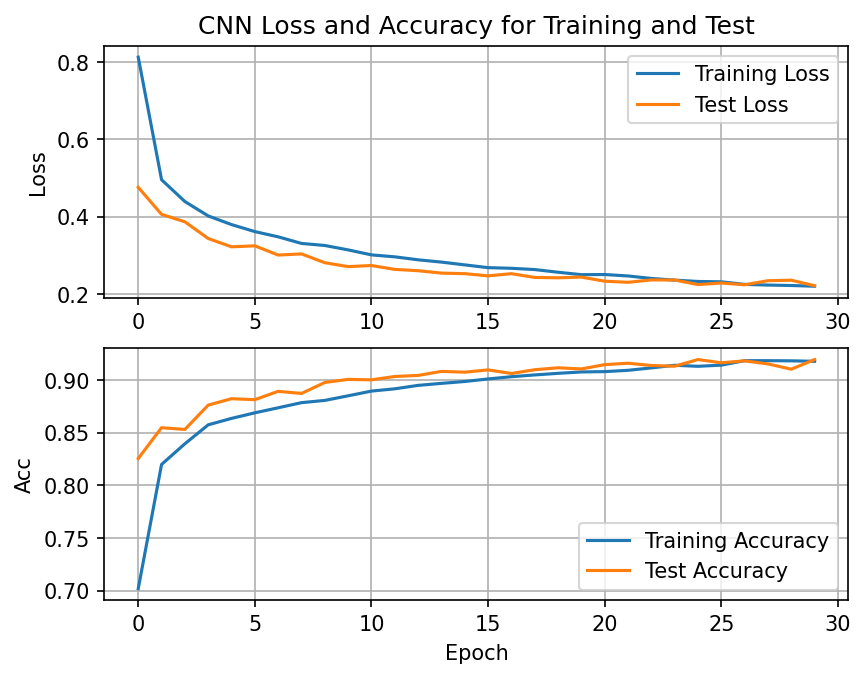

In [13]:
plt.rcParams['figure.dpi'] = 150

plt.subplot(211)
plt.plot(el, h['loss'])
plt.plot(el, h['val_loss'])
plt.legend(['Training Loss', 'Test Loss'])
plt.ylabel('Loss')
plt.grid()
plt.title("CNN Loss and Accuracy for Training and Test", )

plt.subplot(212)
plt.plot(el, h['accuracy'])
plt.plot(el, h['val_accuracy'])
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid()


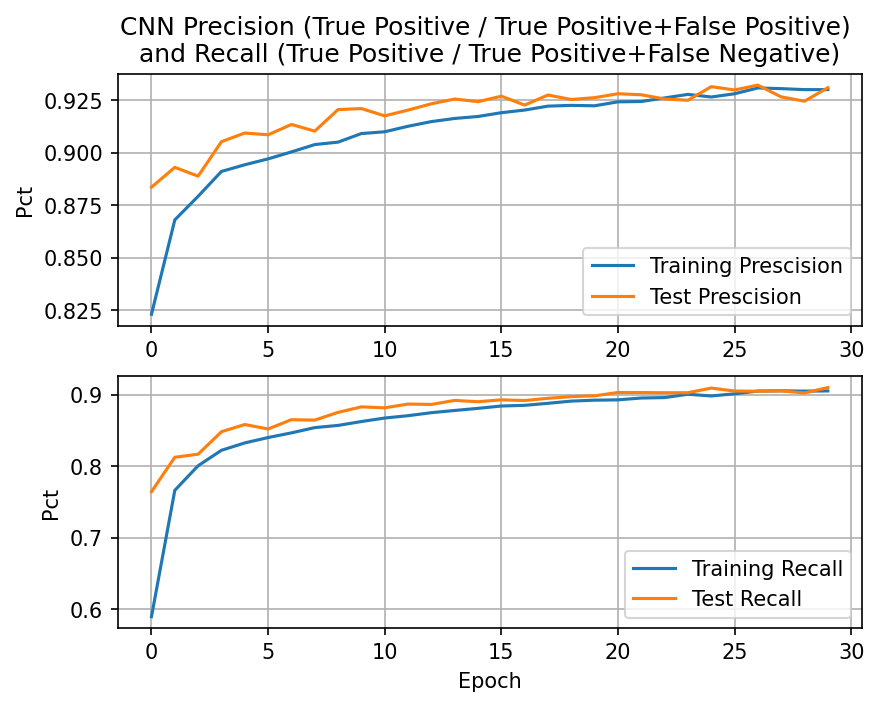

In [14]:
plt.rcParams['figure.dpi'] = 150
ax1 = plt.subplot(211)
plt.grid()
ax1.set_axisbelow(True)
plt.title('CNN Precision (True Positive / True Positive+False Positive) \nand Recall (True Positive / True Positive+False Negative)')
plt.plot(h['precision'])
plt.plot(h['val_precision'])
plt.legend(['Training Prescision', 'Test Prescision'])
plt.ylabel('Pct')
ax2 = plt.subplot(212)
plt.grid()
ax2.set_axisbelow(True)
plt.plot(h['recall'])
plt.plot(h['val_recall'])
plt.xlabel('Epoch')
plt.legend(['Training Recall', 'Test Recall'])
plt.ylabel('Pct')
plt.show()

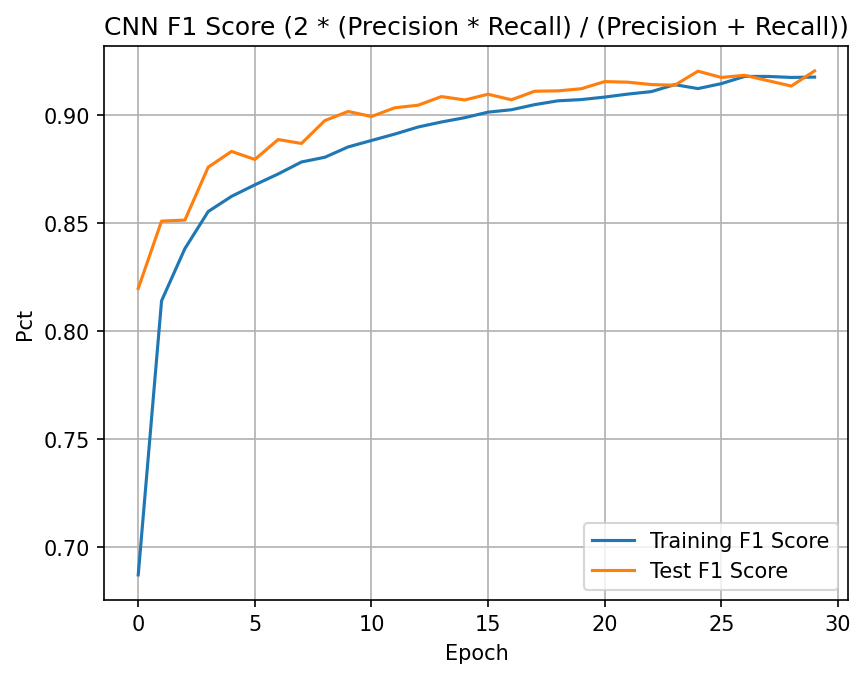

In [15]:
f1 = []
val_f1 = []
for i in range(len(h['recall'])):
    try:
        f1.append(2 * ((h['recall'][i] * h['precision'][i]) /(h['recall'][i] + h['precision'][i])))
        val_f1.append(2 * ((h['val_recall'][i] * h['val_precision'][i]) /(h['val_recall'][i] + h['val_precision'][i])))
    except:
        continue

plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
plt.title('CNN F1 Score (2 * (Precision * Recall) / (Precision + Recall))')
plt.plot(f1)
plt.plot(val_f1)
plt.legend(['Training F1 Score', 'Test F1 Score'])
plt.grid()
ax.set_axisbelow(True)
plt.xlabel('Epoch')
plt.ylabel('Pct')
plt.show()

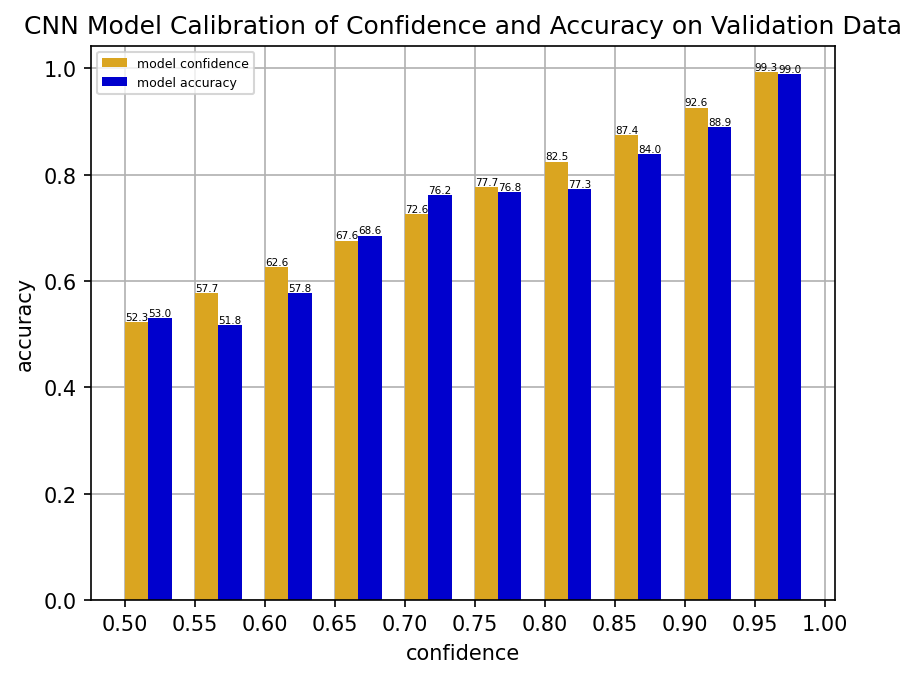

In [18]:
def reliability_stats(y, y_pred, n_bins, n_classes):
    y_hat = np.argmax(y_pred, axis=-1)
    y_conf = np.max(y_pred, axis=-1)
    
    n_samples = len(y)
   
    bin_conf = []
    bin_acc = []
    bin_count = []
    bin_edges = np.linspace(1/2, 1, n_bins+1)
    ece_sum = 0
    for i in range(n_bins):
        idx = np.argwhere(np.logical_and(bin_edges[i] < y_conf, y_conf < bin_edges[i+1]))
        
        if len(idx) == 0:
            bin_conf.append(0)
            bin_acc.append(0)
            bin_count.append(0)
            continue
        
        bc = np.mean(y_conf[idx])
        ba = np.mean(y[idx] == y_hat[idx])
        bn = len(idx)
        
        bin_conf.append(bc)
        bin_acc.append(ba)
        bin_count.append(bn)
        ece_sum += bn * np.abs(bc-ba)
    
    ece = ece_sum / n_samples
    
    return {
        'bin_edges': np.array(bin_edges),
        'bin_conf': np.array(bin_conf),
        'bin_acc': np.array(bin_acc),
        'bin_count': np.array(bin_count),
        'ece': ece
    }

def plot_reliability_diagram(y, ypred, n_bins, n_classes):
    plt.rcParams['figure.dpi'] = 150
    stats = reliability_stats(y, y_pred, n_bins, n_classes)
    bin_conf = stats['bin_conf']
    bin_acc = stats['bin_acc']
    bin_edges = stats['bin_edges']
    ece = stats['ece']
    
    bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2
    bin_width = np.diff(bin_edges)/3
    
    label_conf = [str(round(val * 100, 1)) for val in bin_conf]
    label_acc = [str(round(val * 100, 1)) for val in bin_acc]
    
    fig, ax = plt.subplots()
    p1 = ax.bar(x=bin_edges[:-1]+bin_width/2, height=bin_conf, width=bin_width, color='goldenrod')
    ax.bar_label(p1, labels=label_conf, fontsize=5)
    p2 = ax.bar(x=bin_edges[:-1]+3*bin_width/2, height=bin_acc, width=bin_width, color='mediumblue')
    ax.bar_label(p2, labels=label_acc, fontsize=5)
    plt.grid()
    ax.set_axisbelow(True)
    plt.xticks(bin_edges)
    plt.ylabel('accuracy')
    plt.xlabel('confidence')
    plt.legend(['model confidence', 'model accuracy'], prop={'size': 6})
    plt.title('CNN Model Calibration of Confidence and Accuracy on Validation Data')
    plt.show()

plot_reliability_diagram(y, y_pred, n_bins=10, n_classes=10)           

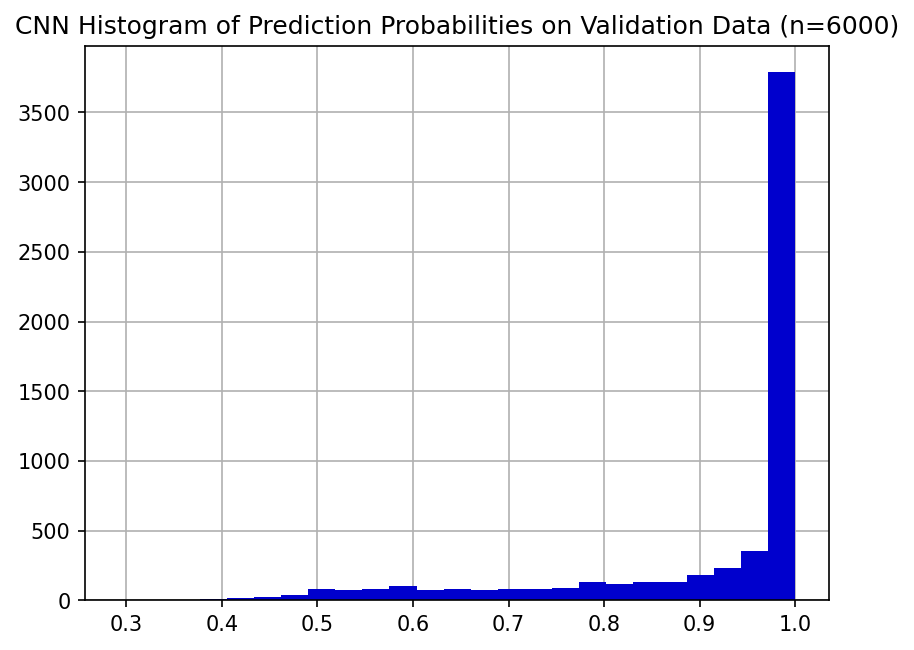

In [19]:
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
plt.title(f"CNN Histogram of Prediction Probabilities on Validation Data (n={len(np.max(y_pred, axis=-1))})")
ax.set_axisbelow(True)
plt.grid()
plt.hist(np.max(y_pred, axis=-1), 25, density=False, color='mediumblue')
plt.show()

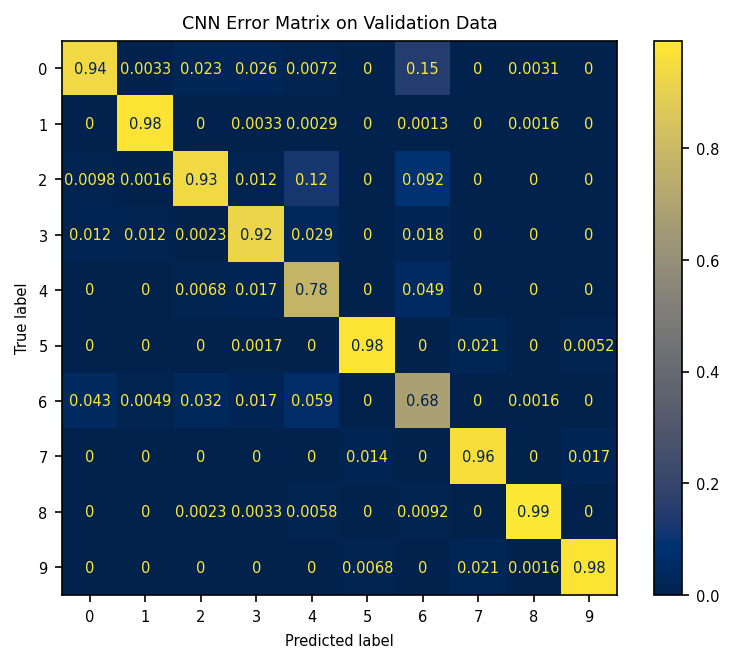

In [20]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 7})
cm = metrics.confusion_matrix(y, yp, normalize='pred', labels=[0,1,2,3,4,5,6,7,8,9])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='cividis')
plt.title("CNN Error Matrix on Validation Data")
plt.show()


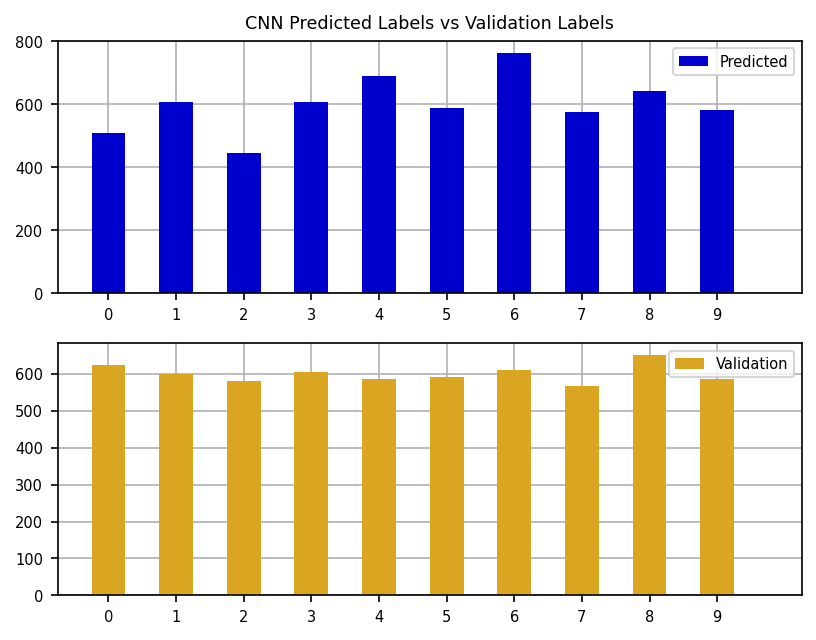

In [21]:
plt.rcParams['figure.dpi'] = 150
ax1 = plt.subplot(211)
plt.hist(np.argmax(y_pred, axis=-1), width=.5, bins=np.arange(11)-0.25, density=False, color='mediumblue')
plt.grid()
ax1.set_axisbelow(True)
plt.legend(['Predicted'])
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.title('CNN Predicted Labels vs Validation Labels')
ax2 = plt.subplot(212)
plt.hist(np.argmax(y_val, axis=-1), width=.5, bins=np.arange(11)-0.25, density=False, color='goldenrod')
plt.grid()
ax2.set_axisbelow(True)
plt.legend(['Validation'])
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

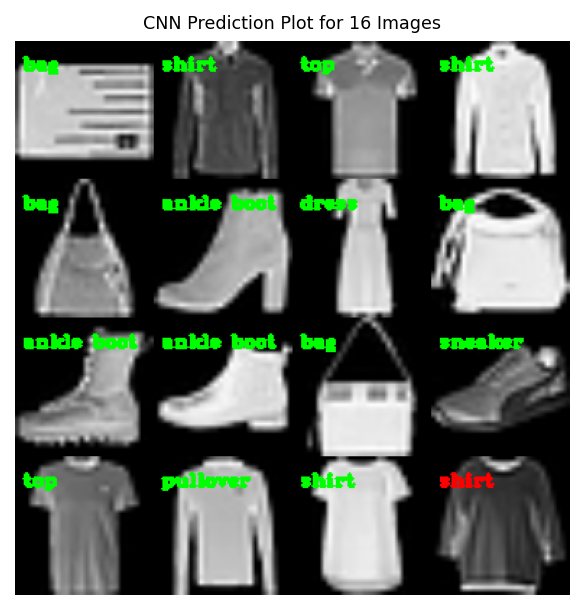

In [23]:
import cv2
from imutils import build_montages
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize list of output images
images = []

# Define labels in correct order
labelNames = ["top", "trouser", "pullover", "dress", "coat",
              "sandal", "shirt", "sneaker", "bag", "ankle boot"]
 
# Randomly select testing fashion items
for i in np.random.choice(np.arange(0, len(y_val)), size=(16,)):
    # Classify the clothing
    probs = model.predict(x_val[np.newaxis, i], verbose=0)
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]
    
    # Extract the image from the testData if using "channels_first" ordering
    if K.image_data_format() == "channels_first":
        image = (x_val[i][0] * 255).astype("uint8")
    # Else use "channels_last" ordering
    else:
        image = (x_val[i] * 255).astype("uint8")

    # Initialize the text label color as green (correct)
    color = (0, 255, 0)
    
    # Otherwise, the class label prediction is red (incorrect) 
    if prediction[0] != np.argmax(y_val[i]):
        color = (255, 0, 0)
    
    # Merge the channels into one image and resize the image from 28x28 to 96x96
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    
    # Draw the predicted label on the image
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.60, color, 2)
    
    # Add the image to list of output images
    images.append(image)
    
# Construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]

# Show the output montage
plt.imshow(montage)
plt.axis('off')
plt.title(f"CNN Prediction Plot for 16 Images")
plt.show()